# Comparison of regression models in predicting next-day stock returns

In [646]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import date, datetime, timedelta
import os
from newsapi.newsapi_client import NewsApiClient
import alpaca_trade_api as tradeapi

In [647]:
import matplotlib.pyplot as plt

In [648]:
import hvplot.pandas

In [649]:
# Set News API Key
newsapi = NewsApiClient(api_key=os.getenv("NEWS_API_KEY"))

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY_ID")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [650]:
# TODO
# Selecting the tickers can be a stand-alone function
# Set the ticker
tickers = ["AAPL", "AMZN", "GOOGL", "NFLX"]

# Set timeframe to '1D'
timeframe = '1D'

# Get current date and the date from one month ago
current_date = date.today()
past_date = date.today() - timedelta(weeks=4)

df = pd.DataFrame()

# Get historical data for AAPL
for tick in tickers:
    tmp_df = api.get_barset(
        tick,
        timeframe,
        limit=1000,
        start=current_date,
        end=past_date,
        after=None,
        until=None,
    ).df
    tmp_df = tmp_df.droplevel(0, axis=1)
    tmp_df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
    tmp_df.rename({'close': tick}, axis=1, inplace=True)
    df = pd.concat([df, tmp_df], axis=1)

# df.head()
len(df)

1000

In [651]:
print(df.head())
print(df.tail())

                            AAPL    AMZN   GOOGL   NFLX
time                                                   
2016-07-08 00:00:00-04:00  96.68  745.82  717.78  97.06
2016-07-11 00:00:00-04:00  96.98  753.78  727.31  94.66
2016-07-12 00:00:00-04:00  97.42  748.21  732.50  95.97
2016-07-13 00:00:00-04:00  96.87  742.74  729.47  96.43
2016-07-14 00:00:00-04:00  98.79  741.19  735.78  98.02
                             AAPL     AMZN    GOOGL    NFLX
time                                                       
2020-06-22 00:00:00-04:00  358.93  2712.00  1450.44  468.08
2020-06-23 00:00:00-04:00  366.37  2764.42  1464.18  465.94
2020-06-24 00:00:00-04:00  360.06  2733.49  1432.17  457.65
2020-06-25 00:00:00-04:00  364.88  2756.16  1441.15  466.14
2020-06-26 00:00:00-04:00  353.69  2692.87  1362.14  443.39


In [652]:
df.index = df.index.date

In [653]:
df.tail()

,AAPL,AMZN,GOOGL,NFLX
2020-06-22,358.93,2712.00,1450.44,468.08
2020-06-23,366.37,2764.42,1464.18,465.94
2020-06-24,360.06,2733.49,1432.17,457.65
2020-06-25,364.88,2756.16,1441.15,466.14
2020-06-26,353.69,2692.87,1362.14,443.39


In [654]:
# Set global variables for consistent testing
short_window = 20
long_window = 100

## AAPL

### Create AAPL df

In [655]:
aapl_df = df.loc[:, 'AAPL'].to_frame()
aapl_df.index = pd.to_datetime(aapl_df.index)
aapl_df.rename(columns={'AAPL': 'close'}, inplace=True)
aapl_df['lag_1_day'] = aapl_df['close'].shift()
aapl_df.dropna(inplace=True)

In [656]:
aapl_df.head()

,close,lag_1_day
2016-07-11,96.98,96.68
2016-07-12,97.42,96.98
2016-07-13,96.87,97.42
2016-07-14,98.79,96.87
2016-07-15,98.76,98.79


In [657]:
# X = aapl_df['AAPL'].copy()
# y = aapl_df['Shift']

In [658]:
aapl_df.close.hvplot(subplots=True, figsize=(12,8))

:Curve   [index]   (close)

In [659]:
aapl_df["return"] = aapl_df["close"].pct_change()
aapl_df.dropna(inplace=True)

In [660]:
aapl_df.head()

,close,lag_1_day,return
2016-07-12,97.42,96.98,0.004537
2016-07-13,96.87,97.42,-0.005646
2016-07-14,98.79,96.87,0.019820
2016-07-15,98.76,98.79,-0.000304
2016-07-18,99.83,98.76,0.010834


In [661]:
short_window_aapl = 20
long_window_aapl = 100

# Exponentially weighted moving average
aapl_df["short_window_ma"] = aapl_df["close"].ewm(halflife=short_window_aapl).mean()
aapl_df["long_window_ma"] = aapl_df["close"].ewm(halflife=long_window_aapl).mean()

# Expoentially weighted volatility
aapl_df["fast_vol"] = aapl_df["return"].ewm(halflife=short_window_aapl).std()
aapl_df["slow_vol"] = aapl_df["return"].ewm(halflife=long_window_aapl).std()

In [662]:
aapl_df.head()

,close,lag_1_day,return,short_window_ma,long_window_ma,fast_vol,slow_vol
2016-07-12,97.42,96.98,0.004537,97.420000,97.420000,NaN,NaN
2016-07-13,96.87,97.42,-0.005646,97.140235,97.144047,0.007200,0.007200
2016-07-14,98.79,96.87,0.019820,97.709322,97.696505,0.012940,0.012842
2016-07-15,98.76,98.79,-0.000304,97.985800,97.965150,0.011017,0.010975
2016-07-18,99.83,98.76,0.010834,98.380639,98.343308,0.009874,0.009892


In [663]:
aapl_df.dropna(inplace=True)

In [664]:
aapl_df.tail()

,close,lag_1_day,return,short_window_ma,long_window_ma,fast_vol,slow_vol
2020-06-22,358.93,349.55,0.026835,314.044976,264.526018,0.025563,0.026917
2020-06-23,366.37,358.93,0.020728,315.827359,265.230218,0.025283,0.026866
2020-06-24,360.06,366.37,-0.017223,317.334085,265.885913,0.025202,0.026824
2020-06-25,364.88,360.06,0.013387,318.953673,266.570398,0.024817,0.026746
2020-06-26,353.69,364.88,-0.030668,320.136920,267.172773,0.025261,0.026797


In [665]:
# Make copy of df for testing without `return` feature
aapl_df_copy = aapl_df.copy()

aapl_df.head()

,close,lag_1_day,return,short_window_ma,long_window_ma,fast_vol,slow_vol
2016-07-13,96.87,97.42,-0.005646,97.140235,97.144047,0.007200,0.007200
2016-07-14,98.79,96.87,0.019820,97.709322,97.696505,0.012940,0.012842
2016-07-15,98.76,98.79,-0.000304,97.985800,97.965150,0.011017,0.010975
2016-07-18,99.83,98.76,0.010834,98.380639,98.343308,0.009874,0.009892
2016-07-19,99.87,99.83,0.000401,98.650858,98.602186,0.009064,0.009114


In [666]:
# X = aapl_df.close.values.reshape(-1, 1)
# X = aapl_df.close.values.reshape(-1, 1)
X_aapl = aapl_df.drop(columns=['lag_1_day'])
y_aapl = aapl_df.lag_1_day.values.reshape(-1, 1)

### Prep data for model fitting

In [667]:
from sklearn.model_selection import train_test_split

X_train_aapl, X_test_aapl, y_train_aapl, y_test_aapl = train_test_split(X_aapl, y_aapl, random_state=0, test_size=0.20)

In [668]:
from sklearn.preprocessing import StandardScaler

scaler_aapl = StandardScaler()

In [669]:
X_train_aapl_scaled, X_test_aapl_scaled = scaler_aapl.fit_transform(X_train_aapl), scaler_aapl.transform(X_test_aapl)

### AAPL with SVR

In [670]:
from sklearn.svm import SVR

svr_aapl = SVR()

In [671]:
svr_aapl.fit(X_train_aapl_scaled, y_train_aapl)

/Users/peterlawson/anaconda3/envs/Viz/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [672]:
SVR_predictions_aapl = svr_aapl.predict(X_test_aapl_scaled)

SVR_predictions_aapl_df = pd.DataFrame({'predictions': SVR_predictions_aapl, 'actual': np.ravel(y_test_aapl)})

In [673]:
SVR_predictions_aapl_df.head()

,predictions,actual
0,152.973967,158.79
1,187.075236,178.25
2,119.453527,108.04
3,167.499613,171.10
4,193.354958,184.93


In [674]:
SVR_predictions_aapl_df.plot(figsize=(12,8))

Error in callback <function flush_figures at 0x7fa955491950> (for post_execute):


KeyboardInterrupt: 

In [675]:
from sklearn.metrics import mean_squared_error

SVR_MSE_aapl = mean_squared_error(y_test_aapl, SVR_predictions_aapl)

print(f"SVR MSE: {SVR_MSE_aapl}")

SVR MSE: 544.3174486272821


### AAPL with Random Forest

In [676]:
from sklearn.ensemble import RandomForestRegressor

rfr_aapl = RandomForestRegressor(max_depth=2, random_state=0)

/Users/peterlawson/anaconda3/envs/Viz/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


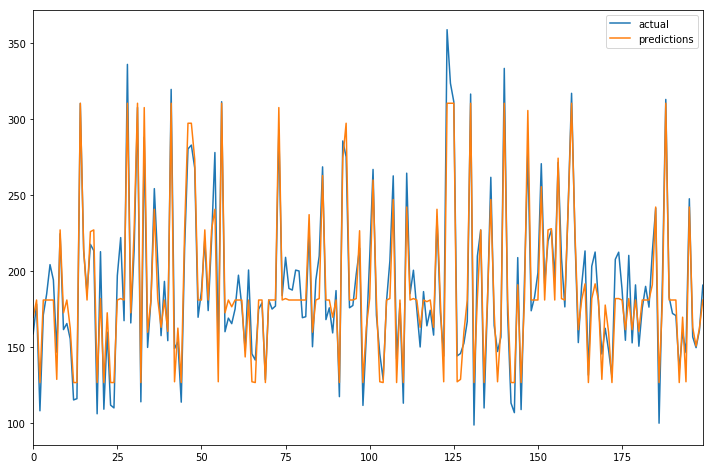

In [677]:
rfr_aapl.fit(X_train_aapl_scaled, y_train_aapl)

RF_predictions_aapl = rfr_aapl.predict(X_test_aapl_scaled)

RF_predictions_aapl_df = pd.DataFrame({'actual': np.ravel(y_test_aapl), 'predictions': RF_predictions_aapl})

RF_predictions_aapl_df.plot(figsize=(12,8))

In [678]:
RF_MSE_aapl = mean_squared_error(y_test_aapl, RF_predictions_aapl)

print(f"SVR MSE: {SVR_MSE_aapl}\nRF_MSE: {RF_MSE_aapl}")

SVR MSE: 544.3174486272821
RF_MSE: 209.975127006197


### AAPL with Gradient Boosting Regressor

In [679]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_aapl = GradientBoostingRegressor(random_state=0)

In [680]:
gbr_aapl.fit(X_train_aapl_scaled, y_train_aapl)

/Users/peterlawson/anaconda3/envs/Viz/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

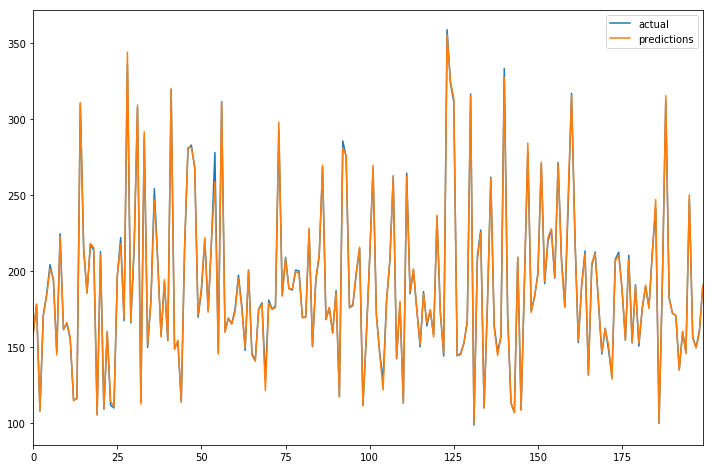

In [681]:
GBR_predictions_aapl = gbr_aapl.predict(X_test_aapl_scaled)

GBR_predictions_aapl_df = pd.DataFrame({'actual': np.ravel(y_test_aapl), 'predictions': GBR_predictions_aapl})

GBR_predictions_aapl_df.plot(figsize=(12,8))

In [682]:
GBR_MSE_aapl = mean_squared_error(y_test_aapl, GBR_predictions_aapl)

print(f"GBR MSE: {GBR_MSE_aapl}\nRF_MSE: {RF_MSE_aapl}\nSVR_MSE: {SVR_MSE_aapl}")

GBR MSE: 5.5439666913035675
RF_MSE: 209.975127006197
SVR_MSE: 544.3174486272821


## AMZN

### Prep data for model fitting

In [683]:
amzn_df = df.loc[:, 'AMZN'].to_frame()
amzn_df.index = pd.to_datetime(amzn_df.index)
amzn_df.rename(columns={'AMZN': 'close'}, inplace=True)
amzn_df['lag_1_day'] = amzn_df['close'].shift()
amzn_df.dropna(inplace=True)

In [684]:
amzn_df.head()

,close,lag_1_day
2016-07-11,753.78,745.82
2016-07-12,748.21,753.78
2016-07-13,742.74,748.21
2016-07-14,741.19,742.74
2016-07-15,735.43,741.19


In [685]:
amzn_df["return"] = amzn_df["close"].pct_change()
amzn_df.dropna(inplace=True)

In [686]:
amzn_df.head()

,close,lag_1_day,return
2016-07-12,748.21,753.78,-0.007389
2016-07-13,742.74,748.21,-0.007311
2016-07-14,741.19,742.74,-0.002087
2016-07-15,735.43,741.19,-0.007771
2016-07-18,736.07,735.43,0.000870


In [687]:
short_window_amzn = 20
long_window_amzn = 100

# Exponentially weighted moving average
amzn_df["short_window_ma"] = amzn_df["close"].ewm(halflife=short_window_amzn).mean()
amzn_df["long_window_ma"] = amzn_df["close"].ewm(halflife=long_window_amzn).mean()

# Expoentially weighted volatility
amzn_df["fast_vol"] = amzn_df["return"].ewm(halflife=short_window_amzn).std()
amzn_df["slow_vol"] = amzn_df["return"].ewm(halflife=long_window_amzn).std()

In [688]:
amzn_df.dropna(inplace=True)

In [689]:
X_amzn = amzn_df.drop(columns=['lag_1_day'])
y_amzn = amzn_df.lag_1_day.values.reshape(-1, 1)

In [690]:
from sklearn.model_selection import train_test_split

X_train_amzn, X_test_amzn, y_train_amzn, y_test_amzn = train_test_split(X_amzn, y_amzn, random_state=0, test_size=0.20)

In [691]:
from sklearn.preprocessing import StandardScaler

scaler_amzn = StandardScaler()

In [692]:
X_train_amzn_scaled, X_test_amzn_scaled = scaler_amzn.fit_transform(X_train_amzn), scaler_amzn.transform(X_test_amzn)

### AMZN with Gradient Boosting Regressor

In [693]:
gbr_amzn = GradientBoostingRegressor(random_state=0)

gbr_amzn.fit(X_train_amzn_scaled, y_train_amzn)

/Users/peterlawson/anaconda3/envs/Viz/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

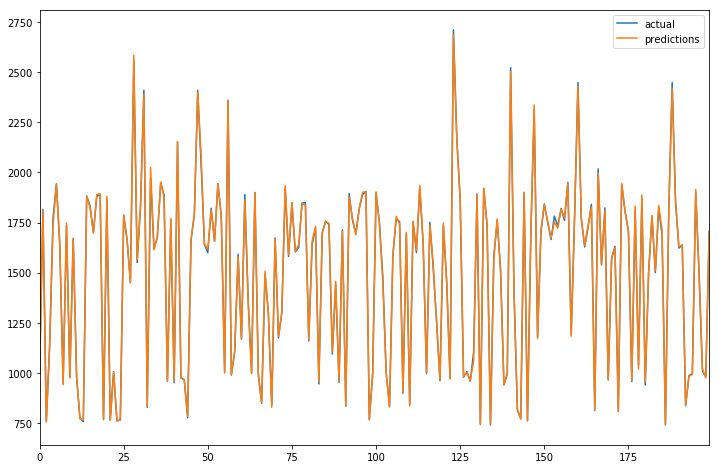

In [694]:
GBR_predictions_amzn = gbr_amzn.predict(X_test_amzn_scaled)

GBR_predictions_amzn_df = pd.DataFrame({'actual': np.ravel(y_test_amzn), 'predictions': GBR_predictions_amzn})

GBR_predictions_amzn_df.plot(figsize=(12,8))

In [695]:
from sklearn.metrics import mean_squared_error

GBR_MSE_amzn = mean_squared_error(y_test_amzn, GBR_predictions_amzn)

print(f"GBR2_MSE: {GBR_MSE_amzn}")

GBR2_MSE: 135.7422034494428


In [696]:
print(f"GBR AMZN: {gbr_amzn.score(X_test_amzn_scaled, y_test_amzn)}")
print(f"GBR AAPL: {gbr_aapl.score(X_test_aapl_scaled, y_test_aapl)}")
print(f"RFR AAPL: {rfr_aapl.score(X_test_aapl_scaled, y_test_aapl)}")
print(f"SVR AAPL: {svr_aapl.score(X_test_aapl_scaled, y_test_aapl)}")

GBR AMZN: 0.9993429120638333
GBR AAPL: 0.9980456306316214
RFR AAPL: 0.925979180757702
SVR AAPL: 0.8081162085732194


### AMZN with Multi-layer Perceptron Regressor

/Users/peterlawson/anaconda3/envs/Viz/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


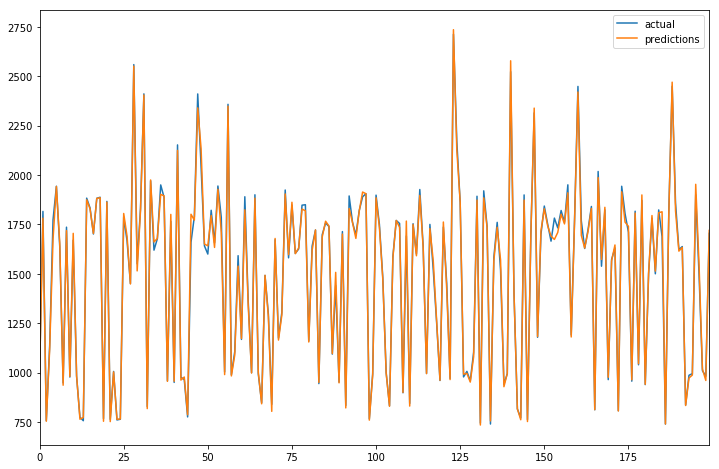

In [697]:
from sklearn.neural_network import MLPRegressor

# Fit with unscaled training data
amzn_mlpr = MLPRegressor(random_state=0, max_iter=500).fit(X_train_amzn, y_train_amzn)

MLPR_predictions_amzn = amzn_mlpr.predict(X_test_amzn)

MLPR_predictions_amzn_df = pd.DataFrame(
    {'actual': np.ravel(y_test_amzn),
     'predictions': MLPR_predictions_amzn
    }
)

MLPR_predictions_amzn_df.plot(figsize=(12,8))

In [698]:
amzn_mlpr.score(X_test_amzn, y_test_amzn)

0.9959111095225214

In [699]:
X_amzn_train_2 = X_amzn.iloc[0:800]
X_amzn_test_2 = X_amzn.iloc[800:]

y_amzn_train_2 = y_amzn[0:800]
y_amzn_test_2 = y_amzn[800:]

In [700]:
mlp = MLPRegressor(random_state=0, max_iter=500).fit(X_amzn_train_2, y_amzn_train_2)

mlp.score(X_amzn_test_2, y_amzn_test_2)

/Users/peterlawson/anaconda3/envs/Viz/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.980807437470873